# Assignment 3a: Pattern Mining and Recommender Systems: Individual Code

### Hasnain Hossain, a1945656

As part of Task 3, the System Integration phase of this project, we need to combine the contributions from Pattern Mining and Collaborative Filtering.

We will implement the functionality from the two modules by bringing the implementation from the `.py` file.

Provided below are the `PatternMining.py` and `CollaborativeFiltering.py` files, corresponding to Tasks 1 and 2. Provided under each code block is also a short method description.

The `CollaborativeFiltering` implementation uses an item-based approach, and `PatternMining` implements both the APriori and the FP-Growth algorithms.

The GitHub repository for the codebase can be found *[here](https://github.com/rizalhamdana/mbd_7306_assignment_3/tree/master)*

We can run some cursory exploration of the dataset to understand the implementations of pattern mining and collaborative filtering better

In [2]:
from collections import Counter
from datetime import datetime
from pathlib import Path
from os import path

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import collections
import itertools
import tempfile
import pprint
import json
import ast
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [3]:
DATA_PATH = 'data'
DATA_FILE = 'Groceries data train.csv'

df_raw_train = pd.read_csv(path.join(DATA_PATH, DATA_FILE))

df_raw_train = df_raw_train.dropna(how='all')

# Sort in case dataset is not sorted
# df_raw_train = df_raw_train.sort_values('Date')

print(df_raw_train.shape)
df_raw_train.head()

(19382, 7)


,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351.0,1/01/2014,cleaner,2014.0,1.0,1.0,2.0
1,2226.0,1/01/2014,sausage,2014.0,1.0,1.0,2.0
2,1922.0,1/01/2014,tropical fruit,2014.0,1.0,1.0,2.0
3,2943.0,1/01/2014,whole milk,2014.0,1.0,1.0,2.0
4,1249.0,1/01/2014,citrus fruit,2014.0,1.0,1.0,2.0


In [4]:
# Convert and clean data types
df_raw_train['Date'] = pd.to_datetime(df_raw_train['Date'], format="%d/%m/%Y")
df_raw_train['User_id'] = df_raw_train['User_id'].astype('Int64')
df_raw_train['year'] = df_raw_train['year'].astype('Int64')
df_raw_train['month'] = df_raw_train['month'].astype('Int64')
df_raw_train['day'] = df_raw_train['day'].astype('Int64')
df_raw_train['day_of_week'] = df_raw_train['day_of_week'].astype('Int64')

# Basic info
num_users = df_raw_train['User_id'].nunique()
num_items = df_raw_train['itemDescription'].nunique()
num_transactions = len(df_raw_train)

summary = {
    "Unique Users": num_users,
    "Unique Items": num_items,
    "Total Transactions": num_transactions,
    "Date Range": (df_raw_train['Date'].min(), df_raw_train['Date'].max())
}

summary


{'Unique Users': 3493,
 'Unique Items': 167,
 'Total Transactions': 19382,
 'Date Range': (Timestamp('2014-01-01 00:00:00'),
  Timestamp('2015-01-20 00:00:00'))}

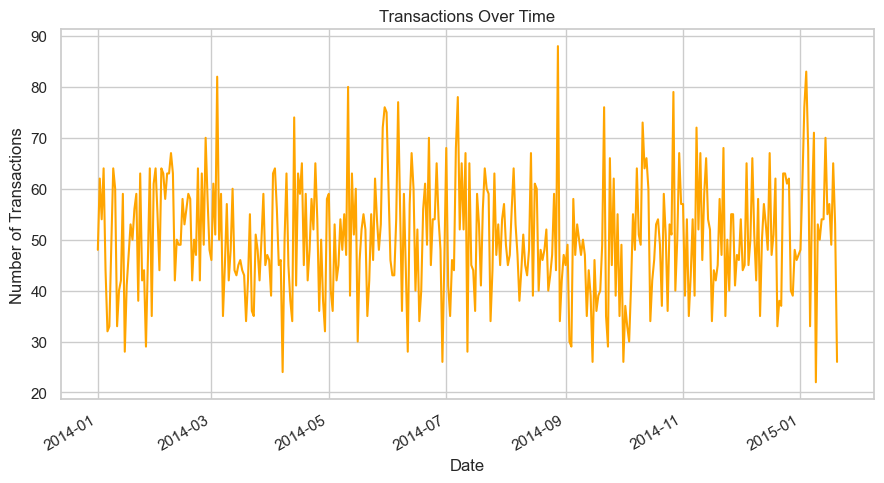

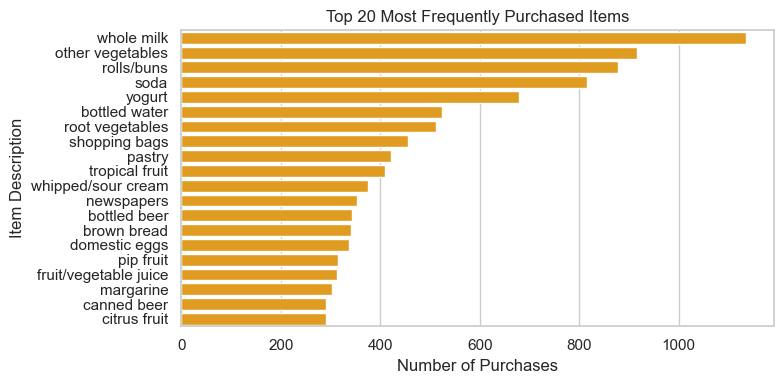

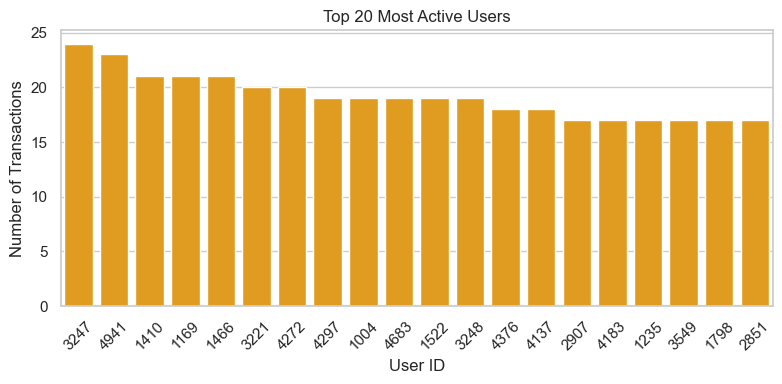

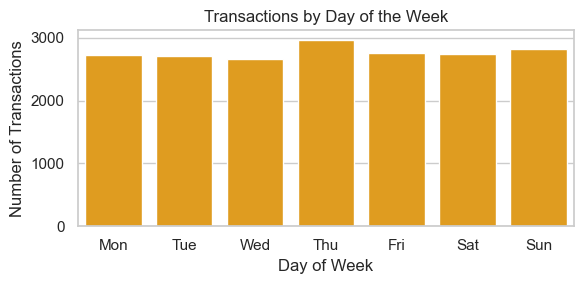

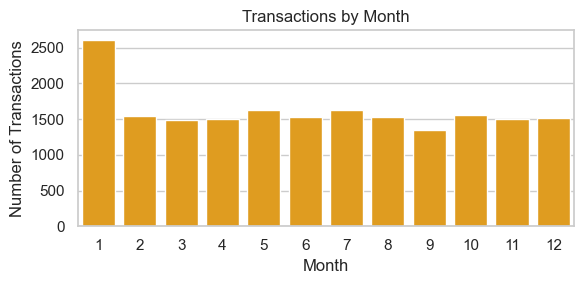

In [73]:
# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 3)

# Transactions over time
transactions_over_time = df_raw_train.groupby('Date').size()

plt.figure(figsize=(9, 5))
transactions_over_time.plot(color='orange')
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

# Most frequently purchased items
top_items = df_raw_train['itemDescription'].value_counts().head(20)

plt.figure(figsize=(8, 4))
sns.barplot(y=top_items.index, x=top_items.values, color='orange')
plt.title("Top 20 Most Frequently Purchased Items")
plt.xlabel("Number of Purchases")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()

# Most active users
top_users = df_raw_train['User_id'].value_counts().head(20)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, color="orange")
plt.title("Top 20 Most Active Users")
plt.ylabel("Number of Transactions")
plt.xlabel("User ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transactions per day of week
dow = df_raw_train['day_of_week'].value_counts().sort_index()

plt.figure()
sns.barplot(x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], y=dow.values, color="orange")
plt.title("Transactions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

# Transactions per month
monthly = df_raw_train['month'].value_counts().sort_index()

plt.figure()
sns.barplot(x=monthly.index, y=monthly.values, color="orange")
plt.title("Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()


While this gives us a basic understanding of the shape and distributions of the transactions, we can actually dig a little deeper, consolidating the transactions into itemsets and baskets, and attempting to visualize their distribution and sparsity. They might help us reason about our experimental approach.

Let's identify and display the grouped transaction data (i.e., baskets of items bought together per user per date). We willl show a sample of the grouped transactions

In [5]:
df_raw_vis = df_raw_train.copy()
df_raw_vis['Date'] = pd.to_datetime(df_raw_vis['Date'], format="%d/%m/%Y")

# Parse date and create a unique transaction ID (User + Date)
df_raw_vis['Basket_ID'] = df_raw_vis['User_id'].astype(str) + "_" + df_raw_vis['Date'].dt.strftime("%Y-%m-%d")

# Step 3: Group items by transaction to form baskets
transactions_series = df_raw_vis.groupby('Basket_ID')['itemDescription'].apply(list)

grouped_df = transactions_series.reset_index()
grouped_df.columns = ["Basket_ID", "Items"]
sample_grouped = grouped_df.sample(10, random_state=42)

# Check a random sample of itemsets
sample_grouped.head()

,Basket_ID,Items
3159,2532_2014-09-21,"[rolls/buns, bottled water]"
6826,4281_2014-09-03,"[yogurt, hard cheese]"
5050,3444_2014-07-01,"[canned beer, syrup, brown bread, rice]"
6309,4050_2014-07-03,"[UHT-milk, curd, flower (seeds)]"
5388,3600_2014-03-09,"[frankfurter, ice cream]"


In [76]:
# Calculate number of unique items
unique_items = pd.Series([item for sublist in transactions_series for item in sublist])
unique_items_count = unique_items.nunique()

# Count top N most frequent items
top_items_count = unique_items.value_counts().head(20)

# Find number of times each item was purchased
product_summary = unique_items.value_counts().reset_index()
product_summary.columns = ['Item', 'Total Occurrences']

# Customer level summary
customer_summary = df_raw_vis.groupby('User_id').agg({
    'Basket_ID': pd.Series.nunique,
    'itemDescription': 'count'
}).rename(columns={
    'Basket_ID': 'Unique Transactions',
    'itemDescription': 'Total Items Purchased'
})
customer_summary['Avg Items per Transaction'] = customer_summary['Total Items Purchased'] / customer_summary['Unique Transactions']

product_summary.head(20)

,Item,Total Occurrences
0,whole milk,1135
1,other vegetables,916
2,rolls/buns,878
3,soda,816
4,yogurt,678
5,bottled water,525
6,root vegetables,512
7,shopping bags,455
8,pastry,421
9,tropical fruit,410


In [ ]:
customer_summary.head()

,Unique Transactions,Total Items Purchased,Avg Items per Transaction
User_id,,,
1000,1,3,3.000000
1001,3,7,2.333333
1002,2,4,2.000000
1003,3,6,2.000000
1004,7,19,2.714286


The item level summary shows us the total number of times each item was purchased. However, the customer summary shows us for each customer, the number of unique transactions they made, the number of items they purchased, and the average basket size.


Seeing that our dataset looks sparse, we can try to visualize this.

We will plot the following:  
1. Items per Basket histogram: 
2. Unique Items per User histogram
3. Co‑occurrence heat‑map of Top‑20 items
4. Utility‑matrix sparsity plot (50 × 50 sample)

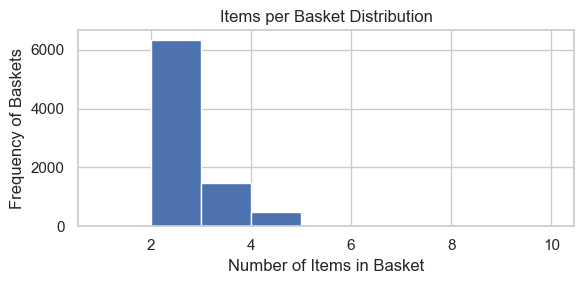

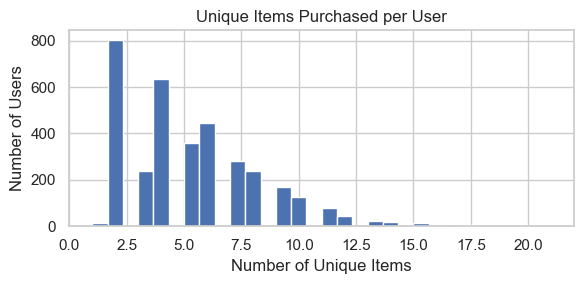

In [ ]:
# We will treat (User_id, Date) as a basket ID

# Histogram of items per basket
basket_sizes = df_raw_vis.groupby('Basket_ID').size()

plt.figure()
plt.hist(basket_sizes, bins=range(1, basket_sizes.max()+2))
plt.title("Items per Basket Distribution")
plt.xlabel("Number of Items in Basket")
plt.ylabel("Frequency of Baskets")
plt.tight_layout()
plt.savefig('hist_items_per_basket.png')
plt.show()

# Histogram of unique items per user
items_per_user = df_raw_vis.groupby('User_id')['itemDescription'].nunique()

plt.figure()
plt.hist(items_per_user, bins=30)
plt.title("Unique Items Purchased per User")
plt.xlabel("Number of Unique Items")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.savefig('hist_items_per_user.png')
plt.show()


From the items per basket distribution, we can see that the majority of baskets contain only 2 or 3 items, with only a small fraction of baskets contain enough items to generate meaningful 2-item or 3-item combinations. The maximum basket size is 9, with an average of 2.32 items. The 90th percentile is 3 items, meaning 90% of all baskets contain 3 items or fewer.

That drastically limits the number of co-occurrences that can appear frequently enough. This means, most transactions look like:

```
['whole milk', 'yogurt']
['rolls/buns']
['soda', 'other vegetables']
```

Consequently, this means our item Distribution is skewed. 

From the unique items purchased histogram, we can see most users interact with just 2–6 unique items, and there are very few power users. 


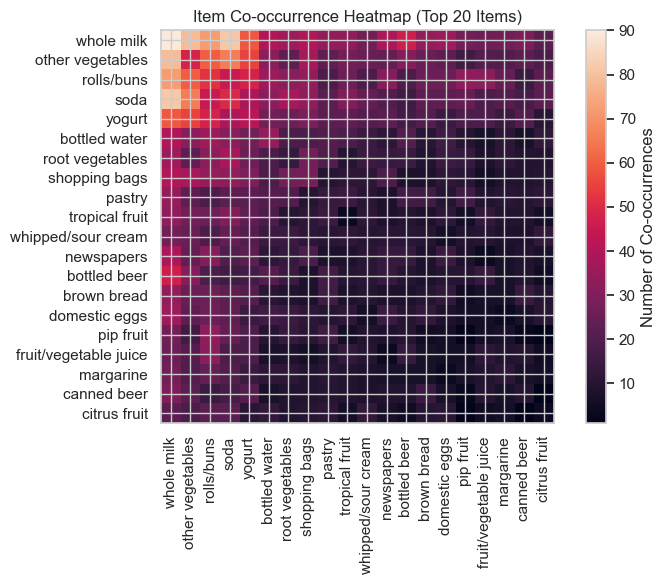

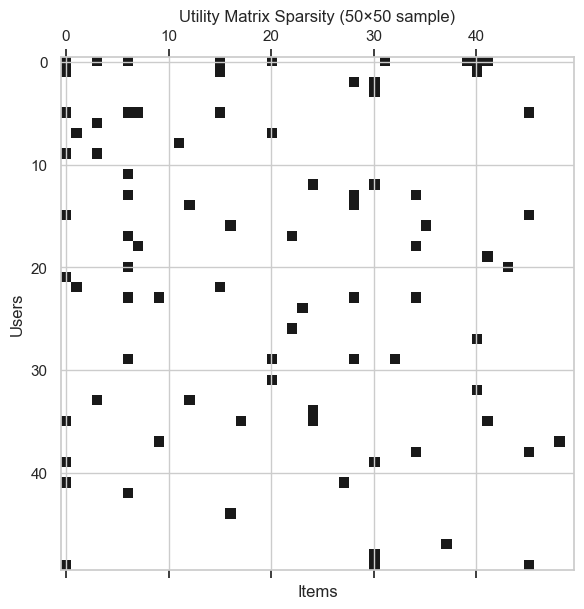

In [ ]:
# Co-occurence heatmap
top_items = df_raw_vis['itemDescription'].value_counts().head(20).index.tolist()
filtered = df_raw_vis[df_raw_vis['itemDescription'].isin(top_items)]
basket_top = (filtered
              .groupby('Basket_ID')['itemDescription']
              .apply(list))

# Build the co-occurrence matrix
co_matrix = pd.DataFrame(np.zeros((20, 20)), index=top_items, columns=top_items)

for items in basket_top:
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            co_matrix.loc[items[i], items[j]] += 1
            co_matrix.loc[items[j], items[i]] += 1

plt.figure(figsize=(8, 6))
plt.imshow(co_matrix, interpolation='nearest')
plt.title("Item Co-occurrence Heatmap (Top 20 Items)")
plt.xticks(ticks=np.arange(20), labels=top_items, rotation=90)
plt.yticks(ticks=np.arange(20), labels=top_items)
plt.colorbar(label="Number of Co-occurrences")
plt.tight_layout()
plt.savefig('co-occurence_heatmap.png')
plt.show()


# Utility matrix sparsity
'''
Note: This is also used within `Collaborative Filtering`
'''
utility = pd.crosstab(df_raw_vis['User_id'], df_raw_vis['itemDescription'])
sample_users = np.random.choice(utility.index, size=50, replace=False)
sample_items = np.random.choice(utility.columns, size=50, replace=False)
sample_matrix = utility.loc[sample_users, sample_items]

plt.figure(figsize=(6, 12))
plt.spy(sample_matrix)
plt.title("Utility Matrix Sparsity (50×50 sample)")
plt.xlabel("Items")
plt.ylabel("Users")
plt.tight_layout()
plt.savefig('utility_matrix_sparsity.png')
plt.show()


Each cell (i, j) in the heatmap represents how many times item i and item j appeared in the same basket. "Whole milk" and "other vegetables" are highly co-purchased (bright square at top-left). These clusters (like "milk/yogurt/bread/vegetables") form natural item groups or bundles. This will allow us to rely on Association-rule–based recommendations, where we can recommend X to people who bought Y.

Each black dot in the matrix indicates a customer bought a given item. Each user interacts with very few items. Most user-item pairs are unknown. Now we can confirm that our matrix is overwhelmingly empty. This is our primary motivation for using item-based collaborative filtering. Cold start problems however, will be a real concern: new users or items will have zero entries.


In [8]:
'''
pattern_mining/PatternMining.py

Task 1
'''
class FlexiblePatternMiner:
    """
    A flexible and modular pattern mining engine supporting Apriori and FP-Growth algorithms.
    Allows configuration of support/confidence/lift thresholds, scoring weights, and rule exports.
    """

    def __init__(self, raw_df, user_col='User_id', item_col='itemDescription', date_col='Date'):
        """
        Initialize the miner with raw transactional data.
        """
        self.raw_df = raw_df.copy().dropna(how='all')
        
        self.user_col = user_col
        self.date_col = date_col
        self.item_col = item_col
        
        self.raw_df[self.date_col] = pd.to_datetime(self.raw_df[self.date_col], dayfirst=True)

        # Encode transactions and compute recency scores
        self.df_encoded = self._encode_transactions()
        self.recency_score = self._compute_recency_scores()

        # Default parameters
        self.min_support = 0.002
        self.min_confidence = 0.04
        self.min_lift = 1.0
        self.selected_algorithms = ['Apriori', 'FP-Growth']
        self.weights = (0.6, 0.4)   # lift, recency

        # Storage
        self.algorithms = {'Apriori': apriori, 'FP-Growth': fpgrowth}
        self.frequent_itemsets = pd.DataFrame()
        self.rules_df = pd.DataFrame()

    def _encode_transactions(self):
        grouped = self.raw_df.groupby(self.user_col)[self.item_col].apply(list).tolist()
        encoder = TransactionEncoder()
        encoded_array = encoder.fit_transform(grouped)
        return pd.DataFrame(encoded_array, columns=encoder.columns_)

    def _compute_recency_scores(self):
        most_recent = self.raw_df[self.date_col].max()
        
        recency_dict = self.raw_df.groupby(self.item_col)[self.date_col].max().apply(lambda x: (most_recent - x).days).to_dict()
        scaler = MinMaxScaler()
        values = np.array(list(recency_dict.values())).reshape(-1, 1)
        scaled = scaler.fit_transform(values).flatten()
        return dict(zip(recency_dict.keys(), scaled))

    def _avg_recency(self, itemset):
        return np.mean([self.recency_score.get(item, 0) for item in itemset])

    def _rule_recency_score(self, row):
        items = list(row['antecedents']) + list(row['consequents'])
        return np.mean([self.recency_score.get(item, 0) for item in items])

    def set_min_support(self, support): self.min_support = support
    def set_min_confidence(self, confidence): self.min_confidence = confidence
    def set_min_lift(self, lift): self.min_lift = lift
    def set_weights(self, gamma, delta): self.weights = (gamma, delta)
    def set_selected_algorithms(self, algos): self.selected_algorithms = algos
    def get_rules(self): return self.rules_df
    def get_frequent_itemsets(self): return self.frequent_itemsets

    def mine_frequent_itemsets(self):
        all_itemsets = []
        for name in self.selected_algorithms:
            func = self.algorithms[name]
            df_binary_only = self.df_encoded.drop(columns=['recency_score'], errors='ignore')
            itemsets = func(df_binary_only, min_support=self.min_support, use_colnames=True).copy()
            itemsets['algorithm'] = name
            itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
            itemsets['recency_score'] = itemsets['itemsets'].apply(self._avg_recency)
            all_itemsets.append(itemsets)
        self.frequent_itemsets = pd.concat(all_itemsets, ignore_index=True)

    def generate_rules(self):
        all_rules = []
        for algo in self.selected_algorithms:
            itemsets_algo = self.frequent_itemsets[self.frequent_itemsets['algorithm'] == algo]
            rules = association_rules(itemsets_algo, metric="confidence", min_threshold=0.001)
            rules = rules[(rules['confidence'] >= self.min_confidence) & (rules['lift'] >= self.min_lift)]
            if rules.empty:
                continue
            rules['algorithm'] = algo
            rules['recency_score'] = rules.apply(self._rule_recency_score, axis=1)
            all_rules.append(rules)
        self.rules_df = pd.concat(all_rules, ignore_index=True) if all_rules else pd.DataFrame()

    def apply_composite_scoring(self):
        if self.rules_df.empty:
            return
        scaler = MinMaxScaler()
        for metric in ['lift', 'recency_score']:
            self.rules_df[f'{metric}_norm'] = scaler.fit_transform(self.rules_df[[metric]])
        gamma, delta = self.weights
        self.rules_df['composite_score_with_recency'] = (
            gamma * self.rules_df['lift_norm'] +
            delta * self.rules_df['recency_score_norm']
        )

    def get_top_rules(self, top_n=10):
        if self.rules_df.empty:
            return pd.DataFrame()
        top_apriori = self.rules_df[self.rules_df['algorithm'] == 'Apriori'].sort_values(by='composite_score_with_recency', ascending=False).head(top_n)
        top_fp = self.rules_df[self.rules_df['algorithm'] == 'FP-Growth'].sort_values(by='composite_score_with_recency', ascending=False).head(top_n)
        return pd.concat([top_apriori, top_fp], ignore_index=True)[
            ['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']
        ]

    def export_rules(self, prefix="rules"):
        export_cols = [
            'algorithm', 'antecedents', 'consequents', 'support', 'confidence',
            'lift', 'recency_score', 'composite_score_with_recency'
        ]
        self.rules_df[export_cols].to_csv(f"{prefix}_combined.csv", index=False)
        self.rules_df[self.rules_df['algorithm'] == 'Apriori'][export_cols].to_csv(f"{prefix}_apriori.csv", index=False)
        self.rules_df[self.rules_df['algorithm'] == 'FP-Growth'][export_cols].to_csv(f"{prefix}_fpgrowth.csv", index=False)


`_encode_transactions()`: Groups each user’s basket into a list, then runs `TransactionEncoder` to yield a DataFrame of `0`/`1` flags.

`_compute_recency_scores()`: Finds the date of each item’s last purchase, then transforms “days since last” into `[0,1]` via `MinMaxScaler`.

`mine_frequent_itemsets()`: For each chosen algorithm (Apriori or FP-Growth):  

It calls `apriori()`/`fpgrowth()` on `df_encoded` to generate frequent itemsets with raw support. Then tags each with algorithm, length, and their average antecedent recency. Finally concatenates into `self.frequent_itemsets`.

`generate_rules()`: For each algorithm’s itemsets, runs `association_rules(…, metric="confidence")`, then filters rules by `confidence ≥ min_confidence` and `lift ≥ min_lift`. After computing a rule recency score averaging all items’ recency, it stores them in `self.rules_df`.

`apply_composite_scoring()`: Min–max normalizes `[lift, recency_score]` to produce `_norm` columns, then builds a composite score with a parameterized weighting of lift and recency.

`get_top_rules(top_n)`: Returns the top `N` rules per algorithm, sorted by `composite_score_with_recency`

In [49]:
'''
collaborative_filtering/CollaborativeFiltering.py

Task 2
'''
class CollaborativeFiltering:
    ### Put Your Code Here
    def __init__(self, dataset_path, split_to_dev = False):
        if not dataset_path:
            return "Please provide path to the dataset file"
        dataset =  pd.read_csv(dataset_path)
        dataset = dataset.dropna(how='all')
        dataset = dataset.rename(columns={"User_id": "user_id", "Date": "date","itemDescription": "item_description"})
        
        transaction_history = self.__generate_transaction_history(dataset)
        utility_matrix = self.__generate_utility_matrix(dataset)
        item_norm_utility_matrix = self.__generate_normalize_utility_matrix(utility_matrix)
        item_similarity_matrix = self.__generate_item_similarity_matrix(item_norm_utility_matrix)
        
        self.transaction_history = transaction_history
        self.utility_matrix = utility_matrix
        self.item_norm_utility_matrix = item_norm_utility_matrix
        self.item_similarity_matrix = item_similarity_matrix
        

    def __generate_transaction_history(self, dataset):
        transaction_history = dataset.groupby(['user_id', 'date', "year", "month", "day", "day_of_week"]).agg({
            'item_description': list
        }).reset_index()

        transaction_history = transaction_history.rename(columns={"item_description": "items"})
        return transaction_history

    def __generate_utility_matrix(self, dataset):
        utility_matrix = pd.crosstab(dataset['user_id'].astype(int), dataset['item_description'])
        utility_matrix.replace(0, np.nan, inplace=True)
        return utility_matrix
        
      
    def __mean_norm(self, array):
        mean = np.mean(array)
        norm_array = [freq - mean for freq in array]
        return pd.Series(norm_array, index=array.index), mean    

    def __generate_normalize_utility_matrix(self, utility_matrix, type="item"):
        
        axis = 0 if type == "item" else 1
        mean_dict = {}
        
        def apply_mean_norm(x):
            norm_x, mean = self.__mean_norm(x)
            mean_dict[x.name] = mean 
            return norm_x
            
        utility_matrix_normalized = utility_matrix.apply(apply_mean_norm, axis=axis)
        return utility_matrix_normalized
        
    def __generate_item_similarity_matrix(self, norm_utility_matrix):
        filled_matrix = norm_utility_matrix.fillna(0).T  # Transpose: items as rows
    
        similarity = cosine_similarity(filled_matrix)
     
        similarity_dataframe = pd.DataFrame(similarity, 
                                    index=filled_matrix.index, 
                                    columns=filled_matrix.index)

        return similarity_dataframe
  

    def __predict_rating(self, 
                         item_similarity_matrix, 
                         utility_matrix, 
                         user_purchased_items, 
                         target_user, 
                         target_item, 
                         n_neighbour):
        
        
        similar_items = item_similarity_matrix[target_item].drop(index=target_item)
        top_k_items = similar_items.sort_values(ascending=False).head(n_neighbour)
        
        weighted_sum = 0
        similarity_sum = 0
        
        if len(user_purchased_items) < 1:
            return  utility_matrix[target_item].mean() 
        
        for item, similarity in top_k_items.items():
            if item in user_purchased_items:
                rating = utility_matrix.loc[target_user, item]
                if not np.isnan(rating):
                    weighted_sum += similarity * rating
                    similarity_sum += abs(similarity)
    
        return weighted_sum / similarity_sum if similarity_sum != 0 else 0
    
    def __extract_items_from_frozenset(self, frozenset_obj):
        """Extract item names from frozenset string, tuple, or set safely."""
        if isinstance(frozenset_obj, (tuple, set, list)):
            # Already tuple/set/list
            return list(frozenset_obj)

        if isinstance(frozenset_obj, str):
            if frozenset_obj.startswith("frozenset({"):
                content = frozenset_obj[len("frozenset({"):-2]  # remove frozenset({ and })
                items = [item.strip(" '\"") for item in content.split(",")]
                return items
            try:
                evaluated = ast.literal_eval(frozenset_obj)
                if isinstance(evaluated, (tuple, set, list)):
                    return list(evaluated)
            except (ValueError, SyntaxError):
                pass

        # Default fallback
        return []

    def __normalize_scores(self, recommendations):
        if not recommendations:
            return []
        max_score = max(score for _, score in recommendations)
        if max_score == 0:
            return [(item, 0.0) for item, _ in recommendations]
        return [(item, score / max_score) for item, score in recommendations]
    
    def __calculate_confidence_factor(self, k, t):
        alpha = min(t, k) / k * 0.9
        return alpha
    
    def __calculate_sigmoid(self, x, steepness=1.0, midpoint=2.0):
        return 1 / (1 + np.exp(-steepness * (x - midpoint)))
    
    def __get_cf_rule_weight(self, user_transaction_history,
                       n_recommended_items,
                       adaptive_switching_type="confidence_factor",
                       sigmoid_steepness=1.0,
                       sigmoid_midpoint=2.0,
                       ):
    
        history_length = len(user_transaction_history)
        if adaptive_switching_type == "sigmoid":
            user_history_weight = self.__calculate_sigmoid(history_length, 
                                        steepness=sigmoid_steepness, 
                                        midpoint=sigmoid_midpoint)
            cf_weight = 0.7 * user_history_weight
            rule_weight = 0.3 + (0.5 * (1 - user_history_weight))
            return cf_weight, rule_weight

        user_history_weight = self.__calculate_confidence_factor(n_recommended_items, history_length)
        cf_weight = user_history_weight
        rule_weight = 1 - user_history_weight
        
        return cf_weight, rule_weight

        
    def get_normalize_utility_matrix(self):
        return self.item_norm_utility_matrix
        
    def get_utility_matrix(self):
        return self.utility_matrix
    
    def get_item_similarity_matrix(self):
        return self.item_similarity_matrix
    
    def get_association_rules_recommendations(self, purchased_items, association_rules, max_recommendations=50):
        recommendations = {}
        purchased_set = set(purchased_items)
        if len(purchased_set) < 1:
            all_consequents = []
            for _, rule in association_rules.iterrows():
                all_consequents.extend(self.__extract_items_from_frozenset(rule['consequents']))

            most_common = Counter(all_consequents).most_common(max_recommendations)
            return [(item, 1) for item, _ in most_common]
            
        else:
            for _, rule in association_rules.iterrows():
                antecedent_items = self.__extract_items_from_frozenset(rule['antecedents'])
                consequent_items = self.__extract_items_from_frozenset(rule['consequents'])
                
                # Check if any purchased items are in the antecedent
                if any(item in purchased_set for item in antecedent_items):
                    for consequent_item in consequent_items:
                        # Skip if user already has this item
                        if consequent_item in purchased_set:
                            continue
                        rule_score = rule['composite_score_with_recency']
                        
                        # Update recommendations
                        recommendations[consequent_item] = max(
                            recommendations.get(consequent_item, 0),
                            rule_score
                        )
            
            # Sort recommendations by score
            sorted_recommendations = sorted(
                recommendations.items(),
                key=lambda x: x[1],
                reverse=True
            )[:max_recommendations]
            
            return sorted_recommendations
    
    def get_cf_recommended_items(self, target_user, 
                                 n_recommended_items=None, 
                                 n_similar_neighbours = 10):
        
        all_user_ids = self.utility_matrix.index   
        user_unpurchased_items = []
        user_purchased_items = []
        if not target_user in all_user_ids:
            user_unpurchased_items = self.utility_matrix.columns 
        else:
            user_ratings_row = self.utility_matrix.loc[target_user]
            user_unpurchased_items = user_ratings_row[user_ratings_row.isna()].index.tolist()
            user_purchased_items = user_ratings_row[~user_ratings_row.isna()].index.tolist()
            
        rating_predictions = {}
        for target_item in user_unpurchased_items:
            predicted_rating = self.__predict_rating(self.item_similarity_matrix, 
                                                     self.utility_matrix, 
                                                     user_purchased_items, 
                                                     target_user, 
                                                     target_item,
                                                     n_similar_neighbours,
                                                     )
            rating_predictions[target_item] = predicted_rating
        
        recommended_items = sorted(rating_predictions.items(), key=lambda x: x[1], reverse=True)
        if not n_recommended_items:
            return recommended_items
        return recommended_items[:n_recommended_items]
    
    
    
    def weighted_hybrid_cf_recommended_items(self, association_rules, 
                                             cf_recommendations, 
                                             target_user,
                                             adaptive_switching_type="confidence_score"
                                             ):
        user_purchased_items = []
        user_transaction_history = []
        if target_user in self.utility_matrix.index.values: ## If user has transaction history
            user_ratings_row = self.utility_matrix.loc[target_user]
            user_purchased_items = user_ratings_row[~user_ratings_row.isna()].index.tolist()
            user_transaction_history = self.transaction_history[self.transaction_history["user_id"] == target_user]
    
        k = len(cf_recommendations)    
        cf_weight, rule_weight = self.__get_cf_rule_weight(user_transaction_history, k, adaptive_switching_type=adaptive_switching_type)
        association_rules_recommendations = self.get_association_rules_recommendations(user_purchased_items, 
                                                                                  association_rules, 
                                                                                  max_recommendations=k)
        final_scores = {}
        
        # Normalize Both Recommendations
        cf_recs_norm = self.__normalize_scores(cf_recommendations)
        ar_recs_norm = self.__normalize_scores(association_rules_recommendations)
    
        for item, score in cf_recs_norm:
            final_scores[item] = score * cf_weight
            
        for item, score in ar_recs_norm:
            if item in final_scores:
                final_scores[item] += score * rule_weight
            else:
                final_scores[item] = score * rule_weight
        
        # Sort and return top recommendations
        top_recommendations = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:]
        return top_recommendations[:k]
            

All logic lives in `collaborative_filtering/CollaborativeFiltering.py`

`__init__(dataset_path)`:

1. Reads CSV, drops empty rows, renames columns → user_id, date, item_description.  
2. Builds a utility matrix (users × items) via pd.crosstab, replacing zeros with `NaN`.  
3. Mean‑normalizes each item column (so that heavy‑purchase items don’t dominate).  
4. Computes item–item cosine similarities on the de‑meaned matrix.  

We store three DataFrames:
1. `self.utility_matrix` (raw counts with `NaNs`)
2. `self.item_norm_utility_matrix` (zero‑mean columns)
3. `self.item_similarity_matrix` (item vs. item cosine sims)

`__generate_transaction_history(dataset)`: Groups by (user_id, date) → list of items per basket.

`__generate_utility_matrix(dataset)`
`pd.crosstab(user_id, item_description)`: fill 0: `NaN`.

`__generate_normalize_utility_matrix(utility_matrix)`: For each item column, subtracts its mean so heavy items don’t dominate.

`__generate_item_similarity_matrix(norm_matrix)`: Fills `NaN` with `0`, transposes (`items x users`), then `cosine_similarity` to yield `item x item`.

`__predict_rating(...)`: For a given user & unseen item, looks at top K most similar items the user has purchased, and returns a weighted average of their ratings. Returns `0` if there is no overlap.

`get_cf_recommended_items(target_user, n_recommended_items, n_similar_neighbours)`: Returns pure CF predictions. This works as follows:  
1. Finds items the user hasn’t purchased.  
2. Calls __predict_rating for each.  
3. Sorts descending, takes top N.  

`get_association_rules_recommendations(purchased_items, rules_df, max_recommendations)`: Returns rule-based recommendations. 
1. Iterates through the exported rules_df (from the pattern miner).  
2. If a rule’s antecedent intersects the user’s purchased set, it adds the consequents (scored by `composite_score_with_recency`).  
3. Sorts & returns top items by rule score.  

`weighted_hybrid_cf_recommended_items(rules_df, cf_recs, target_user, adaptive_switching_type)`: Blends CF & rule recs into a hybrid by doing the following:
1. Normalizes both the CF scores and the rule scores to `[0, 1]`.  
2. Computes an adaptive weight (`cf_weight` vs. `rule_weight`) based on the user’s history length.
3. Final score = cf_weight·CF_score + rule_weight·Rule_score.
4. Returns the combined ranking.  

Note that there are also getter and setter methods within the class files.

## Experimental Design

We will describe our experimental pipeline for the project - from data splitting methodology to final evaluation protocol.

### Data Splitting Strategies

| Strategy | How it works | What “falls into DEV”|
| - | - | - |
|Global cut-off date | We pick a single cut date `t_c`.  All `transactions < t_c` fall to train; all `transactions ≥ t_c` go to dev. | The most recent overall period (e.g. last 2 months).
| Per-user “leave-last-k” | For every user, keep their last k baskets (or last x days) as dev; everything earlier is train. | Each user’s own newest baskets.

In terms of splitting the data, we first use `Groceries data train.csv` to split each user’s ordered baskets into an in-time train portion (the first 80 % of their baskets) and a development (dev) portion (the remaining 20 %) using a time-based cutoff. The dev set would drive all of our parameter tuning.

However, we needed to be cautious here: The data has been split so that all transactions from the same day stay together, avoiding mid-day splits, which would yield transactions that would not reflect the true scenario.

We loops over each unique date in order (`sort_index()` ensures chronological order), keeping a running total of how many rows would be included up to each date. As soon as the cumulative count exceeds the target row count, it picks that date. This ensures we only split starting from a clean date boundary.


In [ ]:
'''
eval/date_splitter.py
'''

def split_dataset_by_date(df, ratio):
    '''
    Split dataset based on ratio and date
    '''
    df = df.sort_values("Date")
    total_rows = len(df)
    
    target_split = int(total_rows * ratio)
    cumulative_count = 0
    
    for date, count in df['Date'].value_counts().sort_index().items():
        cumulative_count += count
        
        if cumulative_count >= target_split:
            split_date = pd.to_datetime(date)
            
            train = df[df['Date'] < split_date]
            dev = df[df['Date'] >= split_date]
            
            return train, dev, split_date
    return df, pd.DataFrame(), None

In [ ]:
# Apply the function for 70-30 splits
train_70, dev_70, date_70 = split_dataset_by_date(df_raw_train, 0.7)

# Save to CSV
train_70.to_csv(path.join(DATA_PATH, 'groceries_train_70.csv'), index=False)
dev_70.to_csv(path.join(DATA_PATH, 'groceries_dev_30.csv'), index=False)

We reserved the provided `Groceries data test.csv` as the final hold-out test set.

We use the following block to ensure that the modules function independently, in isolation.

We will then combine them to use them jointly.

Once our splits were in place, we defined two core models to evaluate. First, a baseline collaborative-filtering (CF) model that predicts a score for each unseen item via item–item cosine similarity and mean-normalized purchase counts.

Second, a lift/recency rule-based model: With a mined association rules with Apriori and FP-Growth, we computed lift and an item recency score and normalized each metric to `[0, 1]`. We combined them via a weighted sum (our “composite score”).


### Evaluation Strategy

#### Ranking Strategy

As part of the evaluation strategies to generate insightful and effective recommendations, we require defining a ranking strategy that will help produce a stable set of association rules. Beyond the classical metrics of support, confidence, there exist a plethora of other metrics (Hahsler 2015).

While support and confidence are indispensable for pruning out uninteresting rules, they offer limited granularity for ranking; lift steps in by quantifying deviation from statistical independence, which correlates strongly with user-perceived relevance (GeeksforGeeks 2023). Omiecinski (2003) demonstrated lift often best matches human notions of “interestingness” across domains. Subsequent probabilistic frameworks confirm lift filters out spurious rules more effectively than confidence alone (Hahsler & Hornik 2007). Unlike conviction or leverage, lift is dimensionless and symmetric, making it straightforward to normalize and combine with other `[0,1]` signals (Raschka 2025)​.

Beyond these classic metrics, recency introduces a temporal dimension. Early works by (Dong et al. 1999) and (Liu, Hsu & Ma 2001) introduced time-decay functions to weight recent transactions more heavily, capturing the time-trend of a rule (Choi, Ahn, & Kim 2005). Recent work demonstrates that combining temporal signals with static measures can significantly boost predictive performance in recommendation tasks (Bao et al. 2022).

Recency ensures that our recommendations reflect the customer’s current buying trends rather than stale associations (Choi, Ahn, & Kim 2005). To justify the addition of a recency term as part of the scoring metric, let us consider evolving customer behavior: Grocery preferences change for users, based on seasonal produce, promotions, new product launches. Static support/confidence would ignore this drift; a recency score ensures “fresh” associations are prioritized (Guo & Yu 2020). 

While there is a substantial body of work on temporal or recency-aware association mining (e.g., by partitioning by time windows or weighting recent transactions more heavily) (Darwish & Mahmoud 2019), and a rich literature on static interestingness measures such as lift (IBM 2009), we found no prior paper that unifies lift with a recency score in one composite.

In light of this gap, and guided by our understanding of selecting measures that match application goals, we propose a composite ranking of a weighted combination of lift and recency.

$$
\text{score} = \gamma \cdot \text{lift}_{\text{norm}} + \delta \cdot \text{recency}_{\text{norm}}
$$

Normalization of each term to `[0,1]` makes them directly additive, and weights ($\alpha$, $\beta$) can be chosen via grid search on our dev set. This composite has no direct precedent in the literature—but it stands on two pillars (lift & recency) each with deep theoretical and empirical backing.

| Strategy name | Rule-ranking key | Comment
| - | - | - |
| lift-only baseline | sort rules by lift descending | ignores recency
| recency-only baseline | sort by recency_score descending | ignores strength
| blend candidate | score = $\beta \cdot$ lift + (1-$\beta$) $\cdot$ recency_score | $\beta$ chosen in a grid

#### Performance Metric

In top-K recommendation tasks, we care most about whether we successfully recover the relevant items a user will actually buy next. Evaluations by (Herlocker et al. 2004) emphasize recall’s centrality in top-N tasks.

In scenarios where the number of relevant items per user is small, precision can be inflated by trivial non-relevant “fillers,” whereas recall directly captures the system’s ability to find the few truly relevant items (Sinha & Dhanalakshmi 2022).

Precision@K is the proportion of recommended items in the top-K list that are actually relevant (i.e., in the user’s hidden basket). For our dataset, as each basket contains only a handful of items, precision@K would reward adding arbitrary non‐purchased items to boost the numerator, whereas recall@K stays focused on retrieving the small set of actual items.


#### Dataset Splitting

To keep the temporal order of the dataset, we implemented the `split_dataset_by_date()` function. This allowed for experimentation for the pattern mining and collaborative filtering modules.

To test the end-to-end pipeline, we decided on an approach to compare the predictions against the last transaction of the training set with the dev set, for a user. Exploring the academic space, we discovered that existing evaluation strategies follow almost exactly the same approach, called leave-one-out or next basket recommendation (Kuznetsov, Nesterov & Panov 2023), (Wang et al. 2015), (Shao et al. 2022), (Zhang et al. 2023).

For each user, we train the model using all but their last basket, and evaluate the model by checking if it can predict the items in their last basket. To ensure every user is in the train and dev sets while preserving temporal order and avoiding data leaks we perform the following:

1. Group by User  
2. Sort each user's baskets by date  
3. Keep all baskets except the last in train  
4. Put the last basket in dev  

Because the split is made per user, we can guarantee that every user contributes to both train and dev. If a user transacted only once — that transaction becomes their dev basket, and they’re excluded from train (which is fine — they are cold-start users). Global sorting of the entire dataset is not required: This method preserves the temporal order of each user's interactions and ensures that the model is trained on past data to predict future behavior.

We can consider a simple dataset:

| User_ID | Basket_ID | Date | Items
| - | - | - | - |
| U1 | B1 | 2023-01-01 | [milk, bread]
| U1 | B2 | 2023-01-10 | [butter]
| U2 | B3 | 2023-01-05 | [eggs]
| U2 | B4 | 2023-01-15 | [milk, eggs]
| U3 | B5 | 2023-01-20 | [bread]

Following the grouping, sorting, and splitting, we end up with:

| User_ID | Basket_IDs (by Date) | Train Baskets | Test Basket
| - | - | - | - |
| U1 | B1 (2023-01-01), B2 (2023-01-10) | B1 | B2
| U2 | B3 (2023-01-05), B4 (2023-01-15) | B3 | B4
| U3 | B5 (2023-01-20) | None | B5 (cold start)


In [10]:
'''
eval/stratified_splitter.py
'''
def leave_last_basket_split(df, user_col='user', date_col='Date'):
    '''
    Return TRAIN and DEV DataFrames using leave-last-basket logic.
    '''
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.sort_values(date_col, inplace=True)

    # Drop users with < 2 baskets (need at least train + dev)
    basket_cnt = df.groupby(user_col)['basket_id'].nunique()
    eligible = basket_cnt[basket_cnt >= 2].index
    df = df[df[user_col].isin(eligible)]

    # Mark splits
    def tag(group):
        last = group[date_col].max()
        group['split'] = 'TRAIN'
        group.loc[group[date_col] == last, 'split'] = 'DEV'
        return group

    return df.groupby(user_col, group_keys=False).apply(tag)


In [11]:
'''
eval/metrics.py
'''
def precision_at_k(pred, truth, k):
    return len(set(pred[:k]) & truth) / k

def recall_at_k(pred, truth, k):
    return len(set(pred[:k]) & truth) / len(truth) if truth else 0

def average_precision(pred, truth, k):
    hits, ap = 0, 0.0
    for rank, itm in enumerate(pred[:k], 1):
        if itm in truth:
            hits += 1
            ap += hits / rank
    return ap / len(truth) if truth else 0

def evaluate_batch(results, k=10):
    precs = [precision_at_k(p, t, k) for p, t in results]
    maps  = [average_precision(p, t, k) for p, t in results]
    recs  = [recall_at_k(p, t, k) for p, t in results]
    return dict(
        precision=np.mean(precs),
        recall   =np.mean(recs),
        map      =np.mean(maps)
    )


In [20]:
'''
The following import functions are for use in the .py codebase
This is the primary main.py file.

Assumes that train/dev/test sets already exist.

df_raw_train: raw train.csv file
train_df
'''
# from collaborative_filtering.CollaborativeFiltering import CollaborativeFiltering
# from eval.metrics import precision_at_k, average_precision, evaluate_batch
# from pattern_mining.PatternMining import FlexiblePatternMiner
# from eval.splitter import leave_last_basket_split

DATA_PATH       = 'data'
TRAIN_FILE      = 'Groceries data train.csv'
TRAIN_PATH      = path.join(DATA_PATH, TRAIN_FILE)
TEST_FILE       = 'Groceries data test.csv'
TEST_PATH       = path.join(DATA_PATH, TEST_FILE)
MIN_SUPPORT     = 0.02
MIN_CONFIDENCE  = 0.3
MIN_LIFT        = 0.1
ALGOS           = ['Apriori','FP-Growth']
# Weights for Lift, Recency
k               = 10
GAMMA           = 0.4
DELTA           = 0.2
BETA_GRID       = [0.5, 0.7, 0.9]            # lift weight   (\beta)

df_raw_train = pd.read_csv(TRAIN_PATH, parse_dates=['Date'])

In [13]:
# Save to file
def save_json(json_dict, file_name):
    with open(path.join(DATA_PATH, file_name), 'w') as f:
        json.dump(json_dict, f, indent=2)

In [14]:
df_raw_train.rename(columns={'User_id':'user_id','itemDescription':'item_description', 'Date':'date'}, inplace=True)
df_raw_train['date'] = pd.to_datetime(df_raw_train['date'], format='%d/%m/%Y')
df_raw_train = df_raw_train.dropna(subset=['user_id', 'date'])
df_raw_train['basket_id'] = df_raw_train['user_id'].astype(int).astype(str) + '_' + df_raw_train['date'].dt.strftime('%Y-%m-%d')

split_df = leave_last_basket_split(df_raw_train, user_col='user_id', date_col='date')
train_df = split_df[split_df['split']=='TRAIN'].copy()
dev_df   = split_df[split_df['split']=='DEV'  ].copy()

tmpdir = Path(tempfile.gettempdir())

dev_df.to_csv(path.join(DATA_PATH, 'dev_split.csv'), index=False)

# Helper for precomputing dev basket lookup
dev_baskets = (dev_df.groupby('basket_id')['item_description'].apply(set).to_dict())
train_baskets = (train_df.groupby('basket_id')['item_description'].apply(set).to_dict())

tmp_train_file = Path(tmpdir) / 'train_split.csv'
train_df.to_csv(tmp_train_file, index=True)

# Save baskets to file
dev_baskets_serializable = {bid: list(items) for bid, items in dev_baskets.items()}
train_baskets_serializable = {bid: list(items) for bid, items in train_baskets.items()}
save_json(train_baskets_serializable, 'train_baskets.json')
save_json(dev_baskets_serializable, 'dev_baskets.json')

print(train_df.shape)
train_df.head()

(11183, 9)


/var/folders/z6/l0c98pwx76z10w95gl6pt7vw0000gp/T/ipykernel_90161/1971713297.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(user_col, group_keys=False).apply(tag)


,user_id,date,item_description,year,month,day,day_of_week,basket_id,split
0,2351.0,2014-01-01,cleaner,2014.0,1.0,1.0,2.0,2351_2014-01-01,TRAIN
26,3681.0,2014-01-01,whipped/sour cream,2014.0,1.0,1.0,2.0,3681_2014-01-01,TRAIN
27,1440.0,2014-01-01,yogurt,2014.0,1.0,1.0,2.0,1440_2014-01-01,TRAIN
28,2974.0,2014-01-01,whipped/sour cream,2014.0,1.0,1.0,2.0,2974_2014-01-01,TRAIN
29,2727.0,2014-01-01,frozen potato products,2014.0,1.0,1.0,2.0,2727_2014-01-01,TRAIN


In [15]:
def recommend_rules(basket, rules_df, k=10):
    """
    Recommend top-k items using *only* the association-rule model.

    Parameters
    ----------
    basket : set
        The user’s current (query) basket.
    miner : FlexiblePatternMiner
        A fitted miner whose `rules_df` already contains
        'composite_score_with_recency'.
    k : int, default 30
        Number of items to return.

    Returns
    -------
    list
        Ranked list of item IDs (length ≤ k) not already in `basket`.
    """
    # 1. candidate rules whose antecedent ⊆ basket
    hits = rules_df[rules_df['antecedents'].apply(lambda a: set(a).issubset(basket))]

    # 2. collect & score consequents
    candidate_scores, seen = {}, set(basket)
    ranked = hits.sort_values('composite_score_with_recency', ascending=False)
    for cons, score in zip(ranked['consequents'],
                           ranked['composite_score_with_recency']):
        for item in cons:
            if item not in seen and item not in candidate_scores:
                candidate_scores[item] = score

    # 3. top-k by score
    return [i for i, _ in
            sorted(candidate_scores.items(), key=lambda x: -x[1])][:k]


In [ ]:
# ---- 3. Create experiments folder and new subfolder ----
os.makedirs('experiments', exist_ok=True)
exp_name = f"exp_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
exp_dir = os.path.join('experiments', exp_name)
os.makedirs(exp_dir, exist_ok=True)

RULES_FILE = path.join(DATA_PATH, 'rules_fpgrowth_recency.csv')
ruleset = pd.read_csv(RULES_FILE)

def clean_frozenset_string(s):
    if isinstance(s, str) and s.startswith("frozenset"):
        # Remove "frozenset(" and ")"
        s = s[len("frozenset("):-1]
    return ast.literal_eval(s)

ruleset = pd.read_csv(RULES_FILE)

# ruleset['antecedents'] = ruleset['antecedents'].apply(clean_frozenset_string).apply(tuple)
# ruleset['consequents'] = ruleset['consequents'].apply(clean_frozenset_string).apply(tuple)

cf_model = CollaborativeFiltering(str(tmp_train_file))

# 5. HYBRID θ GRID
def recommend_hybrid(user_id, ruleset, cf_model, k=10):
    '''
    Return top-k recommendations for *user_id* using the CF + Rule fusion
    implemented inside CollaborativeFiltering.

    Parameters
    ----------
    user_id : int
        Target user.
    last_train_basket : set
        The user’s final basket in the TRAIN split (antecedent context).
    miner : FlexiblePatternMiner
        Fitted miner holding rules_df.
    cf_model : CollaborativeFiltering
        Fitted CF model (utility matrix + similarity).
    k : int
        Length of recommendation list to return.

    Returns
    -------
    list[str]
        Ranked list of item IDs (length ≤ k).
    '''
    # 1. Pure-CF list produced by the class method
    cf_recs = cf_model.get_cf_recommended_items(
                  user_id,
                  n_recommended_items=k)

    # 2. Use built-in fusion (CF + Association Rules)
    hybrid = cf_model.weighted_hybrid_cf_recommended_items(
                 association_rules  = ruleset,
                 cf_recommendations = cf_recs,
                 target_user        = user_id,
                 adaptive_switching_type="confidence_score")
    return [itm for itm, _ in hybrid][:k]

results_rule, results_cf, results_hybrid = [], [], []
for bid, truth in dev_baskets.items():
    uid    = int(bid.split('_')[0])
    basket = train_baskets.get(bid, set())

    # rule-only
    results_rule.append((recommend_rules(basket, ruleset, k=k), truth))

    # cf-only
    cf_only = [i for i,_ in cf_model.get_cf_recommended_items(uid, n_recommended_items=k)]
    results_cf.append((cf_only, truth))

    # hybrid
    results_hybrid.append((recommend_hybrid(uid, ruleset, cf_model, k), truth))

scores_rule   = evaluate_batch(results_rule,   k=k)
scores_cf     = evaluate_batch(results_cf,     k=k)
scores_hybrid = evaluate_batch(results_hybrid, k=k)
print("DEV Prec@10  Rule :", scores_rule['precision'])
print("DEV Prec@10  CF   :", scores_cf['precision'])
print("DEV Prec@10  Hybrid:", scores_hybrid['precision'])

# 6. MERGE TRAIN+DEV  ➜ FULL-TRAIN refit CF + Rules
full_train = split_df.query("split!='TEST'").copy()
tmp_full_file = Path(tmpdir) / "full_train.csv"
full_train.to_csv(tmp_full_file, index=False)
cf_full    = CollaborativeFiltering(str(tmp_full_file))

# 7. TEST evaluation  ─────────────────────────────────────────────
test_raw = pd.read_csv(TEST_PATH, parse_dates=['Date'])
test_raw.rename(columns={'User_id':'user_id', 'itemDescription':'item_description', 'Date':'date'}, inplace=True)
test_raw = test_raw.dropna(subset=['user_id', 'date'])
test_raw['basket_id'] = (test_raw['user_id'].astype(int).astype(str) + '_' + test_raw['date'].dt.strftime('%Y-%m-%d'))
test_baskets = test_raw.groupby('basket_id')['item_description'].apply(set).to_dict()

results=[]
for bid, truth in test_baskets.items():
    # look up user history basket in full_train
    if bid not in full_train['basket_id'].values:     # new user → fall back
        recs = list(ruleset['consequents'].explode().unique())[:k]
    else:
        uid  = int(bid.split('_')[0])
        hist = full_train[full_train['basket_id']==bid]['item_description'].tolist()
        recs = recommend_hybrid(uid, ruleset, cf_full, k)
    results.append((recs, truth))

test_metrics = evaluate_batch(results, k=k)
print("\n──── FINAL TEST METRICS ────")
pprint.pprint(test_metrics)


DEV Prec@10  Rule : 0.0
DEV Prec@10  CF   : 0.024898125509372454
DEV Prec@10  Hybrid: 0.04327628361858191


/var/folders/z6/l0c98pwx76z10w95gl6pt7vw0000gp/T/ipykernel_90161/2339642070.py:101: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_raw = pd.read_csv(TEST_PATH, parse_dates=['Date'])



──── FINAL TEST METRICS ────
{'map': 0.00015124016938898973,
 'precision': 3.0248033877797946e-05,
 'recall': 0.00030248033877797946}


In [38]:
# ---- 1. Prepare hyperparameters manually ----
hyperparams = {
    "gamma": GAMMA,
    "delta": DELTA,
    "model_type": "hybrid"  # or "cf" or "rules" depending on what you ran
}

# ---- 2. Prepare combined DEV and TEST metrics manually ----
metrics_to_save = {
    "dev_precision": scores_hybrid['precision'],
    "dev_recall": scores_hybrid['recall'],
    "dev_map": scores_hybrid['map'],
    "test_precision": test_metrics['precision'],
    "test_recall": test_metrics['recall'],
    "test_map": test_metrics['map'],
}

# ---- 4. Save configs ----
with open(os.path.join(exp_dir, 'config.json'), 'w') as f:
    json.dump(hyperparams, f, indent=2)

# ---- 5. Save evaluation results (both DEV and TEST) ----
with open(os.path.join(exp_dir, 'results.json'), 'w') as f:
    json.dump(metrics_to_save, f, indent=2)

# ---- 6. Save grid search results ----
# grid_results.to_csv(os.path.join(exp_dir, 'grid_results.csv'), index=False)

# ---- 7. Update experiment summary table ----
summary_path = os.path.join('experiments', 'experiments_summary.csv')
summary_entry = {**hyperparams, **metrics_to_save, "exp_name": exp_name}

if os.path.exists(summary_path):
    summary_df = pd.read_csv(summary_path)
    summary_df = pd.concat([summary_df, pd.DataFrame([summary_entry])], ignore_index=True)
else:
    summary_df = pd.DataFrame([summary_entry])

summary_df.to_csv(summary_path, index=False)

In [61]:
# =========================================
# Text-mode interface for Top-5 suggestions
# Uses:
#   • cf_model  – instance of CollaborativeFiltering
#   • ruleset   – DataFrame with external rules
# Both objects must already be initialised in the notebook.
# =========================================
import pandas as pd

def get_cf_only(user_id: int, k: int = 5) -> list[str]:
    """
    CF-only recommender (no frequent-pattern boost).
    """
    return [itm for itm, _ in
            cf_model.get_cf_recommended_items(user_id,
                                              n_recommended_items=k)]

def get_hybrid(user_id: int, k: int = 5) -> list[str]:
    """
    CF + association-rule fusion provided by the CF class.
    """
    cf_recs = cf_model.get_cf_recommended_items(user_id,
                                                n_recommended_items=k)
    hybrid  = cf_model.weighted_hybrid_cf_recommended_items(
                association_rules  = ruleset,
                cf_recommendations = cf_recs,
                target_user        = user_id,
                adaptive_switching_type="confidence_score")
    return [itm for itm, _ in hybrid][:k]

print("🔮  Grocery Recommender — type 'quit' to exit")
while True:
    raw_uid = input("\nEnter user_id: ").strip()
    if raw_uid.lower() == "quit":
        break
    if not raw_uid.isdigit():
        print("‼  user_id must be an integer."); continue
    uid = int(raw_uid)

    mode = input("With frequent patterns? (with / without): ").strip().lower()
    if mode not in {"with", "without"}:
        print("‼  Please type 'with' or 'without'."); continue

    recs = (get_hybrid(uid, 5) if mode == "with"
            else get_cf_only(uid, 5))

    if not recs:
        print("⚠  No recommendations available for this user.")
    else:
        print(f"\nTop-5 recommendations for user {uid} ({mode}):")
        for i, item in enumerate(recs, 1):
            print(f"{i:2d}. {item}")


🔮  Grocery Recommender — type 'quit' to exit

Top-5 recommendations for user 3004 (with):
 1. other vegetables
 2. soda
 3. rolls/buns
 4. yogurt
 5. bottled water

Top-5 recommendations for user 3004 (without):
 1. whole milk
 2. other vegetables
 3. soda
 4. rolls/buns
 5. yogurt

Top-5 recommendations for user 3005 (with):
 1. bottled water
 2. UHT-milk
 3. beef
 4. bottled beer
 5. cake bar

Top-5 recommendations for user 3005 (without):
 1. UHT-milk
 2. beef
 3. bottled beer
 4. bottled water
 5. cake bar
‼  user_id must be an integer.
‼  user_id must be an integer.
‼  user_id must be an integer.
‼  user_id must be an integer.


In [ ]:
'''
We will first ensure that the modules function correctly in isolation.
Then we will merge them into a single unit
'''

# Sample user and num_items
n_recommended_items = 5
user_id = 1000

# Collaborative Filtering
cf = CollaborativeFiltering(TRAIN_PATH)

# 4. RULE MINER GRID (β, λ)  ─────────────────────────────────────
grid_results = []

cf_recs = cf.get_cf_recommended_items(user_id, n_recommended_items=n_recommended_items)

print(f'Recommendations of {n_recommended_items} items for user {user_id}:\n')
for item, value in cf_recs:
    print(f"('{item:<14}', {value:.2f})")

# Pattern Mining
engine = FlexiblePatternMiner(train_df,
    user_col='User_id',
    item_col='itemDescription',
    date_col='Date'
)
engine.set_min_support(MIN_SUPPORT)
engine.set_min_confidence(MIN_CONFIDENCE)
engine.set_min_lift(MIN_LIFT)
engine.set_selected_algorithms(ALGOS)
engine.set_weights(ALPHA, BETA, GAMMA, DELTA)

engine.mine_frequent_itemsets()
itemsets = engine.get_frequent_itemsets()

engine.generate_rules()

# Apply composite scoring to the same ruleset dataframe
engine.apply_composite_scoring()

rules = engine.get_rules()
print("Top 3 rules:\n", rules[['algorithm','antecedents','consequents','composite_score_with_recency']].head(3))


# References

1. Hahsler, M 2015, A probabilistic comparison of commonly used interest measures for association rules, viewed 19 April 2025, https://mhahsler.github.io/arules/docs/measures.  
2. Choi, D-H, Ahn, B-S & Kim, S-H 2005, Prioritization of association rules in data mining: Multiple criteria decision approach’, Expert Systems with Applications, vol. 29, no. 4, pp. 867–878, DOI:10.1016/j.eswa.2005.06.006.  
3. Bao, F, Mao, L, Zhu, Y, Xiao, C & Xu, C 2022, ‘An improved evaluation methodology for mining association rules’, Axioms, vol. 11, no. 1, p. 17, DOI:10.3390/axioms11010017.
4. GeeksforGeeks 2023, Association rule, viewed 19 April 2025, https://www.geeksforgeeks.org/association-rule/.
5. Darwish, SM & Mahmoud, AR 2019, ‘A new temporal association rules mining approach for huge database’, International Journal of Computers, vol. 13, pp. 1–10, viewed 19 April 2025, https://www.naun.org/main/NAUN/computers/2019/a342007-027.pdf.​
6. IBM 2009, Data mining — Lift in an association rule, IBM Documentation, viewed 19 April 2025, https://www.ibm.com/docs/en/db2/9.7.0?topic=associations-lift-in-association-rule.​
7. Hahsler, M & Hornik, K 2007, ‘New probabilistic interest measures for association rules’, Intelligent Data Analysis, vol. 11, no. 5, pp. 437–455, DOI:10.3233/IDA-2007-11502.
8. Raschka, S 2025, lift_score: Lift score for classification and association rule mining, mlxtend Documentation, viewed 19 March 2025, https://rasbt.github.io/mlxtend/user_guide/evaluate/lift_score/.​
9. Guo, Q & Yu, F 2020, ‘A method for mining temporal association rules in single-attributed graph sequence’, in Fuzzy Information and Engineering-2019, Advances in Intelligent Systems and Computing, vol. 1094, Springer, Singapore, pp. 51–61, DOI:10.1007/978-981-15-2459-2_4.
10. Dong, G, Zhang, X, Wong, L & Li, J 1999, ‘Efficient mining of emerging patterns: discovering trends and differences’, Proceedings of the fifth ACM SIGKDD international conference on Knowledge discovery and data mining, ACM, New York, NY, pp. 43–52, DOI:10.1145/312129.312191.
11. Liu, B, Hsu, W & Ma, Y 2001, ‘Integrating classification and association rule mining’, Expert Systems with Applications, vol. 18, no. 2, pp. 99–105, DOI:10.1016/S0957-4174(01)00037-9.​
12. Herlocker, JL, Konstan, JA, Terveen, LG & Riedl, JT 2004, ‘Evaluating collaborative filtering recommender systems’, ACM Transactions on Information Systems, vol. 22, no. 1, pp. 5–53, DOI:10.1145/963770.963772.
13. Sinha, BB & Dhanalakshmi, R 2022, ‘Evolution of recommender paradigm optimization over time’, Journal of King Saud University – Computer and Information Sciences, vol. 34, no. 4, pp. 1047–1059, DOI:10.1016/j.jksuci.2019.06.008.
14. Wang, P, Guo, J, Lan, Y, Xu, J, Wan, S & Cheng, X 2015, ‘Learning hierarchical representation model for next basket recommendation’, Proceedings of the 38th International ACM SIGIR Conference on Research and Development in Information Retrieval, ACM, New York, NY, pp. 403–412, DOI:10.1145/2766462.2767694.​
15. Shao, Z, Wang, S, Zhang, Q, Lu, W, Li, Z & Peng, X 2022, ‘A systematical evaluation for next-basket recommendation algorithms’, Proceedings of the 2022 IEEE 9th International Conference on Data Science and Advanced Analytics (DSAA), IEEE, Piscataway, NJ, pp. 1041–1050, DOI:10.1109/DSAA54385.2022.10032359.​
16. Zhang, Y, Chen, H, Li, X, Wang, Y, Zhang, Y, & Liu, Y 2023, ‘Take a fresh look at recommender systems from an evaluation standpoint’, Proceedings of the 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR '23), ACM, New York, NY, pp. 1–10, DOI:10.1145/3539618.3591931.
17. Kuznetsov, A, Nesterov, A, & Panov, M 2023, ‘Time-aware item weighting for the next basket recommendations’, Proceedings of the 17th ACM Conference on Recommender Systems (RecSys '23), ACM, New York, NY, pp. 1–10, DOI:10.1145/3604915.3608859.